## Setup: 
Setup conda/mamba environment as specified in https://github.com/LorenFrankLab/spyglass/blob/master/environment.yml

In [1]:
import datajoint as dj
import sys
import os

# dj.config['database.host'] = "" # enter datajoint host url
# dj.config['database.user'] = "" # enter datajoint username
# dj.config['database.port'] = 3306
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
dj.config.load("dj_local_conf.json")

from spyglass.common.common_behav import StateScriptFile
from spyglass.common.common_task import TaskEpoch
from spyglass.common.common_nwbfile import AnalysisNwbfile
sys.path.append("..")
from trial_info import TrialInfo

[2024-05-28 16:32:43,419][INFO]: Connecting molly@gl-ash.biostr.washington.edu:3306
[2024-05-28 16:32:43,441][INFO]: Connected molly@gl-ash.biostr.washington.edu:3306


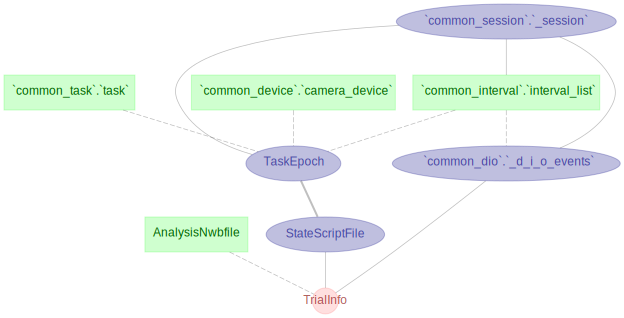

In [2]:
dj.Diagram(TaskEpoch) + dj.Diagram(TrialInfo) - 1

In [3]:
TrialInfo.heading

# 
nwb_file_name        : varchar(64)                  # name of the NWB file
epoch                : int                          # the session epoch for this task and apparatus(1 based)
dio_event_name       : varchar(80)                  # the name assigned to this DIO event
---
analysis_file_name   : varchar(64)                  # name of the file
trial_info_object_id : varchar(40)                  # the NWB object ID for loading this object from the file
parser               : varchar(100)                 # type of parser used to interpret statescript log
descriptors=null     : blob                         # global descriptors for task

## Inserting epochs from a single session:
Alternatively, we can populate using all entries in the StateScriptFile table. Here, we test inserting a single session.

In [2]:
nwb_file_name = "bobrick20231204_.nwb"

In [5]:
TrialInfo.populate(StateScriptFile & {'nwb_file_name' : nwb_file_name})

[15:47:50][INFO] Spyglass: Skipping sleep epoch: bobrick20231204_.nwb, epoch 1
[15:47:51][INFO] Spyglass: Writing new NWB file bobrick20231204_VEUNTEK7TR.nwb
[15:47:53][INFO] Spyglass: Skipping sleep epoch: bobrick20231204_.nwb, epoch 3
[15:47:54][INFO] Spyglass: Writing new NWB file bobrick20231204_VP8WVUK9BP.nwb
[15:47:56][INFO] Spyglass: Skipping sleep epoch: bobrick20231204_.nwb, epoch 5


In [38]:
TrialInfo()

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),dio_event_name the name assigned to this DIO event,analysis_file_name name of the file,trial_info_object_id the NWB object ID for loading this object from the file,parser type of parser used to interpret statescript log,descriptors global descriptors for task
bobrick20231204_.nwb,2,homebeam,bobrick20231204_DVD9RJH3OK.nwb,a4891338-e78e-4ef9-8e3a-42f89356a7ef,V8_delay,=BLOB=
bobrick20231204_.nwb,4,homebeam,bobrick20231204_1IAHIJH04X.nwb,3df00258-8c8d-47fd-8ef9-398f0b263e85,V8_delay,=BLOB=
bobrick20231205_.nwb,2,homebeam,bobrick20231205_HGLGUKLF75.nwb,7ee2b2d1-77ea-49ef-8bd7-e460ec9dee6a,V8_delay,=BLOB=
bobrick20231205_.nwb,4,homebeam,bobrick20231205_DLQD553DDE.nwb,2df6fd4a-d258-495d-a9f1-81fa14eef33d,V8_delay,=BLOB=
chip20220101_.nwb,2,homebeam,chip20220101_X9LMXJJVAX.nwb,58eb330a-624f-4933-9d8e-832b5314d7c6,V8_delay,=BLOB=
herman20211114_.nwb,2,homebeam,herman20211114_C0Q1MQH0E4.nwb,d335091f-eda0-4989-97d7-b2603f1e71fd,V8_delay,=BLOB=
herman20211114_.nwb,4,homebeam,herman20211114_LB7B243MSA.nwb,c1f30cb1-4c35-411e-b575-21521c77ee50,V8_delay,=BLOB=
pippin20210401_.nwb,2,homebeam,pippin20210401_T565DCD3HL.nwb,fd25ad69-aa43-4950-a0ac-69f2925c9ca0,V8_delay,=BLOB=
pippin20210401_.nwb,4,homebeam,pippin20210401_73DE2T7KOQ.nwb,cc4005d6-fe70-4fb8-b3e4-f65c4fee5231,V8_delay,=BLOB=


## Reading the resulting analysis file

In [3]:
# select a specific epoch for the inserted session
restr = {"nwb_file_name": nwb_file_name, "epoch": 2}

In [4]:
# accessing trial descriptors
(TrialInfo & restr).fetch1("descriptors")

{'statescript': 'V8pre_delay_locknoise_uw.sc',
 'lockout_period': 30.0,
 'python_script': 'V8.py',
 'outer_reps': [4, 13],
 'num_goals': 1,
 'forage_num': 1}

In [4]:
# fetching dataframe for the specified run epoch
df = (TrialInfo & restr).fetch1_dataframe()
df

,trial_num,start_time,end_time,leave_home,trial_type,rw_start,rw_end,leave_rw,rw_success,outer_well,goal_well,outer_time,leave_outer,outer_success,lockout_starts,lockout_ends,during_lockout,lockout_type
id,,,,,,,,,,,,,,,,,,
0,1,1.701714e+09,1.701714e+09,1.701714e+09,2,1.701714e+09,1.701714e+09,1.701714e+09,1,0.0,6.0,0.000000e+00,0.000000e+00,0,[1701714449.1414883],[1701714479.1414883],"[8, 10, 1, 1]",1
1,2,1.701714e+09,1.701715e+09,1.701714e+09,2,1.701714e+09,1.701714e+09,1.701715e+09,1,4.0,6.0,1.701715e+09,1.701715e+09,0,[],[],[],0
2,3,1.701715e+09,1.701715e+09,1.701715e+09,2,1.701715e+09,1.701715e+09,1.701715e+09,1,7.0,6.0,1.701715e+09,1.701715e+09,0,[],[],[],0
3,4,1.701715e+09,1.701715e+09,1.701715e+09,1,1.701715e+09,1.701715e+09,1.701715e+09,1,10.0,6.0,1.701715e+09,1.701715e+09,0,[],[],[],0
4,5,1.701715e+09,1.701715e+09,1.701715e+09,2,1.701715e+09,1.701715e+09,1.701715e+09,1,5.0,6.0,1.701715e+09,1.701715e+09,0,[],[],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,102,1.701718e+09,1.701718e+09,1.701718e+09,2,1.701718e+09,1.701718e+09,1.701718e+09,1,5.0,5.0,1.701718e+09,1.701718e+09,1,[],[],[],0
102,103,1.701718e+09,1.701718e+09,1.701718e+09,1,1.701718e+09,1.701718e+09,1.701718e+09,1,5.0,5.0,1.701718e+09,1.701718e+09,1,[],[],[],0
103,104,1.701718e+09,1.701718e+09,1.701718e+09,2,1.701718e+09,1.701718e+09,1.701718e+09,1,5.0,5.0,1.701718e+09,1.701718e+09,1,[],[],[],0


In [9]:
# vscode widget: run this cell to get an interactive plot
%matplotlib ipympl

# Uncomment this widget instead for jupyter notebook:
#%matplotlib notebook


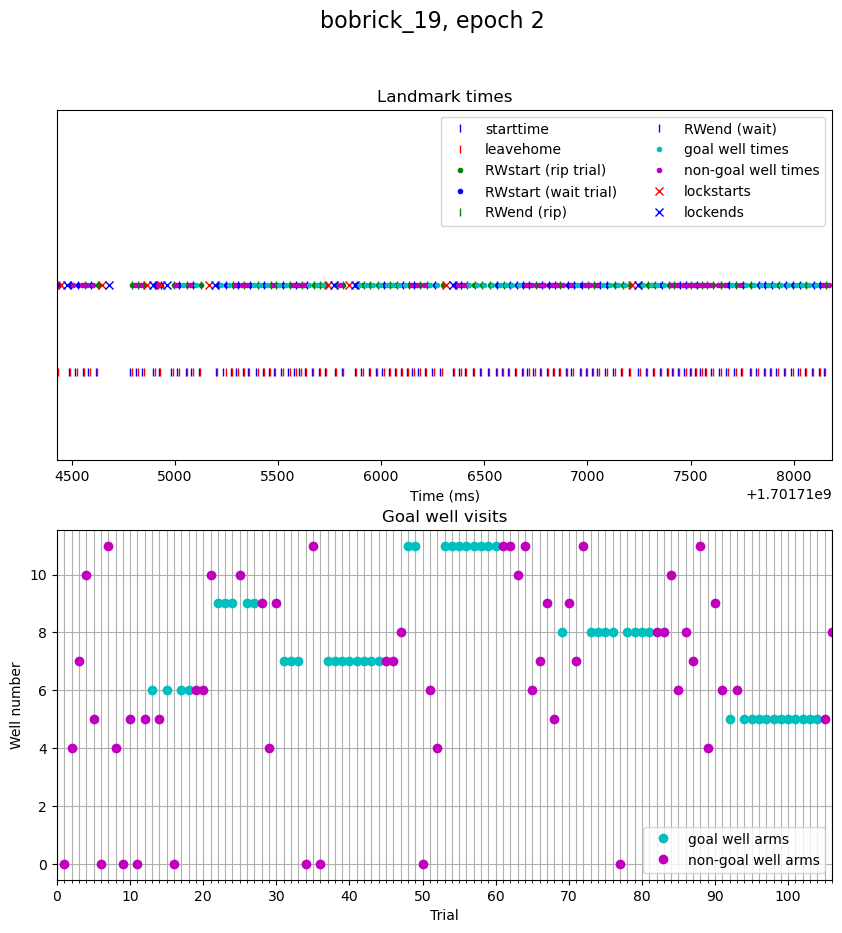

In [5]:
# optional: visualize landmark times during epoch
(TrialInfo & restr).plot_trials()

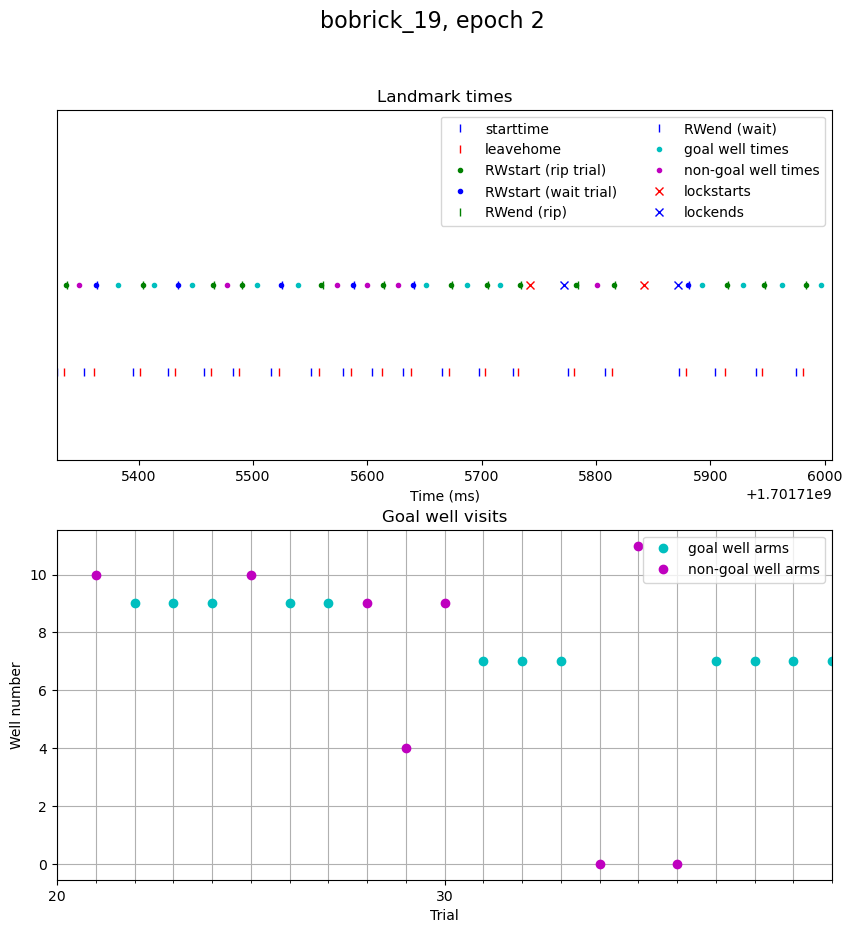

In [6]:
# alternatively, select a smaller interval of trials
(TrialInfo & restr).plot_trials(start=20, end=40)

### Sample analysis: calculating moving reward rates

Execute helper methods `get_goal_fractions` and `plot_goal_fractions` to visualize reward rate aligned to the most recent goal-change / reward trial

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
def get_goal_fractions(df):
    
    num_trials = len(df)
    goals = df["goal_well"].to_numpy()
    goal_change_trials = np.where(np.diff(goals, prepend=0, append=num_trials) != 0)[0]

    # boolean mask: is_goal[i] = 1 iff goal arm was visited on trial i
    goal_trials = df.index[df.outer_well == df.goal_well].to_numpy()

    is_goal = np.zeros(num_trials, dtype=int)
    is_goal[goal_trials] = 1

    # map each trial to the number of trials that have passed since last goal-change / reward
    since_goal_change = np.zeros_like(goals)
    since_goal_found = np.zeros_like(goals)
    since_goal_found.fill(-1)
    first_goals = []
    for i in range(1, goal_change_trials.size):
        block_start = goal_change_trials[i-1]
        block_end = goal_change_trials[i]

        first_goal = block_start
        while first_goal < block_end and not is_goal[first_goal]:
            first_goal += 1 # increment until we find first goal trial within block
        if first_goal < block_end:
            first_goals.append(first_goal)
        
        counts_since_change = np.arange(1, block_end - block_start + 1)
        counts_since_found = counts_since_change - (first_goal - block_start) # align to first goal trial of block
        since_goal_change[block_start:block_end] = counts_since_change
        since_goal_found[block_start:block_end] = counts_since_found

    # calculating goal fractions wrt trials since goal-change / reward
    cumulative_goals = np.cumsum(is_goal) # cg[i] = cumulative # of goals up to and including trial i
    # cg[j] - cg[i] = cumulative goals at trial j made since trial i 

    goal_fraction_since_change = np.zeros(num_trials)
    goal_fraction_since_found = np.zeros(num_trials)
    goal_fraction_since_found.fill(-1)

    for i in range(1, goal_change_trials.size):
        block_start = goal_change_trials[i-1]
        block_end = goal_change_trials[i]
        if i == 1: # fenceposting
            goal_fraction_since_change[block_start:block_end] = cumulative_goals[block_start:block_end] / since_goal_change[block_start:block_end]
        else:
            goal_fraction_since_change[block_start:block_end] = (cumulative_goals[block_start:block_end] - cumulative_goals[block_start-1]) / since_goal_change[block_start:block_end]

        first_goal = goal_change_trials[i-1]
        while first_goal < block_end and not is_goal[first_goal]:
            first_goal += 1 # increment until we find first goal trial within block
        if first_goal < block_end:
            goal_fraction_since_found[first_goal:block_end] = (cumulative_goals[first_goal:block_end] - cumulative_goals[first_goal-1]) / since_goal_change[first_goal:block_end]

    # handle divide by 0 instances on 1st trials of each block and reward trials
    goal_fraction_since_change = np.nan_to_num(goal_fraction_since_change)
    goal_fraction_since_found = np.nan_to_num(goal_fraction_since_found)

    data = {}
    data["goal_fraction_since_change"] = goal_fraction_since_change
    data["trials_since_change"] = since_goal_change
    data["goal_fraction_since_found"] = goal_fraction_since_found
    data["trials_since_found"] = since_goal_found
    return data

In [46]:
def plot_goal_fractions(df):
    res = get_goal_fractions(df)
    rr_since_change = res["goal_fraction_since_change"]
    trials_since_change = res["trials_since_change"]
    rr_since_found = res["goal_fraction_since_found"]
    trials_since_found = res["trials_since_found"]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

    ax1.scatter(trials_since_change, rr_since_change)
    ax1.set_xlabel("Trials since last goal change")
    ax1.set_ylabel("Frac. goal arm trials (since start of block)")
    ax1.set_ylim(0, 1)
    ax1.grid()
    # averaging goal fraction across trials of the same distance from the last goal change
    tmp = pd.DataFrame(data={"since_goal_change": trials_since_change, "goal_fraction": rr_since_change})
    avg_goal_fraction = tmp.groupby("since_goal_change").mean().to_numpy().flatten()

    ax1.plot(np.unique(trials_since_change), avg_goal_fraction, "r")

    mask = trials_since_found >= 0

    ax2.scatter(trials_since_found[mask], rr_since_found[mask])
    ax2.set_xlabel("Trials since goal was found")
    ax2.set_ylabel("Frac. goal arm trials (since start of block)")
    ax2.set_ylim(0, 1)
    ax2.grid()
    # averaging goal fraction across trials of the same distance from the last goal change
    tmp = pd.DataFrame(data={"since_goal_found": trials_since_found[mask], "goal_fraction": rr_since_found[mask]})
    avg_goal_fraction = tmp.groupby("since_goal_found").mean().to_numpy().flatten()

    ax2.plot(np.unique(trials_since_found[mask]), avg_goal_fraction, "r")

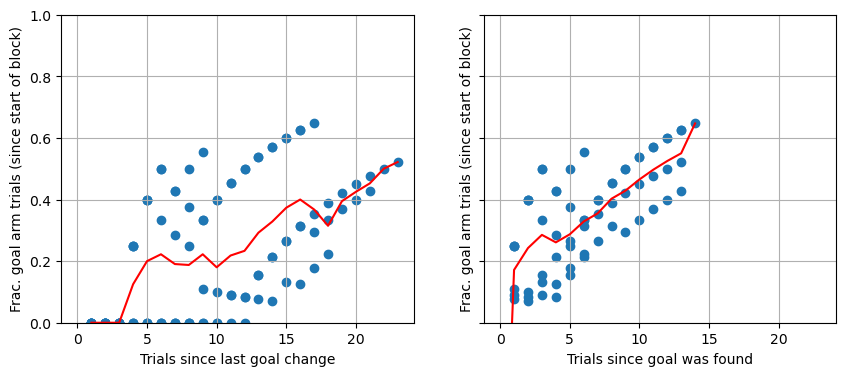

In [47]:
plot_goal_fractions(df)

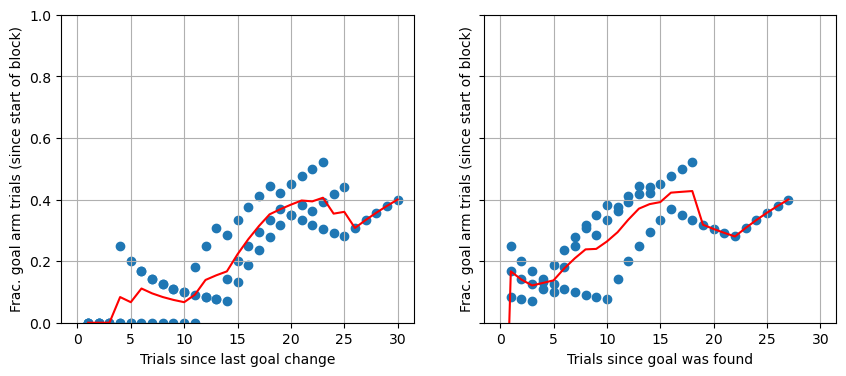

In [51]:
# more plots!
df_ep4 = (TrialInfo & {"nwb_file_name": "herman20211114_.nwb", "epoch": 4}).fetch1_dataframe()
plot_goal_fractions(df_ep4)

## Deleting Entries

In [14]:
# Deletes TrialInfo entries from this session
(TrialInfo & {"nwb_file_name" : nwb_file_name}).delete()

[15:46:51][INFO] Spyglass: Building merge cache for __trial_info.
	Found 0 downstream merge tables


[2024-05-22 15:46:51,583][INFO]: Deleting 2 rows from `trial_info`.`__trial_info`
[2024-05-22 15:46:53,661][INFO]: Deletes committed.


In [15]:
TrialInfo & {"nwb_file_name" : nwb_file_name}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),dio_event_name the name assigned to this DIO event,analysis_file_name name of the file,trial_info_object_id the NWB object ID for loading this object from the file,parser type of parser used to interpret statescript log,descriptors global descriptors for task


In [6]:
# Automatically deletes AnalysisNwbfile entries that are not referenced a downstream table
# AND removes the filepath entries for NWB files that are not in use.
AnalysisNwbfile.nightly_cleanup()

100%|██████████| 4/4 [00:00<00:00, 93.11it/s]
